<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install statstests

In [2]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
from tqdm import tqdm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')
df.shape

(14363, 26)

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [5]:
df.head(10)

date_window  frauds  median_amount  max_amount  min_current_age  \
0 2010-01-01 00:00:00       0      39.623106      270.22               30   
1 2010-01-01 06:00:00       0      35.349520     1153.61               28   
2 2010-01-01 12:00:00       0      53.245731     1309.71               28   
3 2010-01-01 18:00:00       1      52.065771      692.30               30   
4 2010-01-02 00:00:00       0      77.233604      843.96               32   
5 2010-01-02 06:00:00       0      50.232666     1411.14               29   
6 2010-01-02 12:00:00       0      50.894781      433.00               29   
7 2010-01-02 18:00:00       0      55.164553      837.29               28   
8 2010-01-03 00:00:00       0      56.809655      436.72               28   
9 2010-01-03 06:00:00       0      40.477784      748.26               28   

   median_current_age  max_current_age  min_per_capita_income  \
0           54.628788              101                    0.0   
1           55.579336              101                    0.0   
2           56.356397               99                    0.0   
3           55.416667               98                    0.0   
4           55.333333               90                10091.0   
5           55.393225              101                    0.0   
6           55.616438               99                    0.0   
7           54.284553               99                    0.0   
8           54.974138               90                    0.0   
9           54.255924              101                    0.0   

   median_per_capita_income  max_per_capita_income  ...  min_num_credit_cards  \
0              22462.931818                55362.0  ...                     1   
1              24074.888069               137428.0  ...                     1   
2              24248.729765               163145.0  ...                     1   
3              24630.685417               137428.0  ...                     1   
4              22904.180180                53676.0  ...                     1   
5              24209.026510               163145.0  ...                     1   
6              24413.727397               163145.0  ...                     1   
7              22062.108401                76725.0  ...                     1   
8              23238.663793                58517.0  ...                     1   
9              23778.003555                91180.0  ...                     1   

   median_num_credit_cards  max_num_credit_cards  median_credit_limit  \
0                 3.946970                     8         16065.136364   
1                 3.979090                     9         15062.613776   
2                 3.881201                     9         15741.868146   
3                 3.831250                     8         14942.864583   
4                 3.900901                     8         14475.153153   
5                 3.918999                     8         15222.743741   
6                 3.909589                     9         15059.013699   
7                 3.953930                     8         14885.262873   
8                 4.060345                     8         15231.551724   
9                 3.960900                     9         15225.849526   

   max_credit_limit  target_city_0  target_city_1  target_description_0  \
0           76343.0            1.0            0.0                   1.0   
1           70187.0            1.0            0.0                   1.0   
2          125723.0            1.0            0.0                   1.0   
3           96637.0            1.0            0.0                   1.0   
4           57294.0            1.0            0.0                   1.0   
5          141391.0            1.0            0.0                   1.0   
6          125723.0            1.0            0.0                   1.0   
7           96637.0            1.0            0.0                   1.0   
8           47833.0            1.0            0.0                   1.0   


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14363 entries, 0 to 14362
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date_window               14363 non-null  datetime64[ns]
 1   frauds                    14363 non-null  int32         
 2   median_amount             14363 non-null  float64       
 3   max_amount                14363 non-null  float64       
 4   min_current_age           14363 non-null  int64         
 5   median_current_age        14363 non-null  float64       
 6   max_current_age           14363 non-null  int64         
 7   min_per_capita_income     14363 non-null  float64       
 8   median_per_capita_income  14363 non-null  float64       
 9   max_per_capita_income     14363 non-null  float64       
 10  min_total_debt            14363 non-null  float64       
 11  median_total_debt         14363 non-null  float64       
 12  max_total_debt    

In [7]:
df.describe().T

count                           mean  \
date_window                 14363  2014-12-01 10:40:50.797187328   
frauds                    14363.0                       0.894103   
median_amount             14363.0                      54.107561   
max_amount                14363.0                     866.673407   
min_current_age           14363.0                       25.68022   
median_current_age        14363.0                      53.933532   
max_current_age           14363.0                      98.307596   
min_per_capita_income     14363.0                    1711.870501   
median_per_capita_income  14363.0                    23782.34984   
max_per_capita_income     14363.0                  118297.238042   
min_total_debt            14363.0                      17.644642   
median_total_debt         14363.0                   57825.287232   
max_total_debt            14363.0                  356932.003063   
min_credit_score          14363.0                     495.148576   
median_credit_score       14363.0                      714.46272   
max_credit_score          14363.0                      849.49544   
min_num_credit_cards      14363.0                       1.000766   
median_num_credit_cards   14363.0                        3.85602   
max_num_credit_cards      14363.0                       8.501845   
median_credit_limit       14363.0                    15473.54161   
max_credit_limit          14363.0                   101980.87976   
target_city_0             14363.0                        0.99996   
target_city_1             14363.0                       0.000004   
target_description_0      14363.0                       0.999948   
target_description_2      14363.0                       0.000019   
previous_frauds           14363.0                       0.233726   

                                          min                  25%  \
date_window               2010-01-01 00:00:00  2012-06-16 21:00:00   
frauds                                    0.0                  0.0   
median_amount                       30.616345            48.409608   
max_amount                             102.13              523.915   
min_current_age                          23.0                 24.0   
median_current_age                       26.0            53.289989   
max_current_age                          26.0                 98.0   
min_per_capita_income                     0.0                  0.0   
median_per_capita_income               9710.0         23440.364872   
max_per_capita_income                  9710.0              94302.0   
min_total_debt                            0.0                  0.0   
median_total_debt                       686.0         56021.744364   
max_total_debt                          686.0             242379.0   
min_credit_score                        488.0                489.0   
median_credit_score                     682.0           711.931169   
max_credit_score                        682.0                850.0   
min_num_credit_cards                      1.0                  1.0   
median_num_credit_cards                   2.0             3.803813   
max_num_credit_cards                      2.0                  8.0   
median_credit_limit                     974.0         15110.864497   
max_credit_limit                        974.0              70187.0   
target_city_0                        0.971963                  1.0   
target_city_1                             0.0                  0.0   
target_description_0                 0.990741                  1.0   
target_description_2                      0.0                  0.0   
previous_frauds                           0.0                  0.0   

                                          50%                  75%  \
date_window               2014-12-01 12:00:00  2017-05-17 03:00:00   
frauds                                    0.0                  0.0   
median_amount                       54.423702            59.521218   
max_amount          

## Implementação de Modelos

In [8]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [9]:
y.shape

(14363,)

In [10]:
y.value_counts().sort_index()

frauds
0     11006
1       975
2       646
3       393
4       304
5       257
6       177
7       163
8       111
9        88
10       69
11       55
12       37
13       23
14       17
15       14
16        8
17        2
18        8
19        5
20        1
21        1
23        1
26        1
35        1
Name: count, dtype: int64

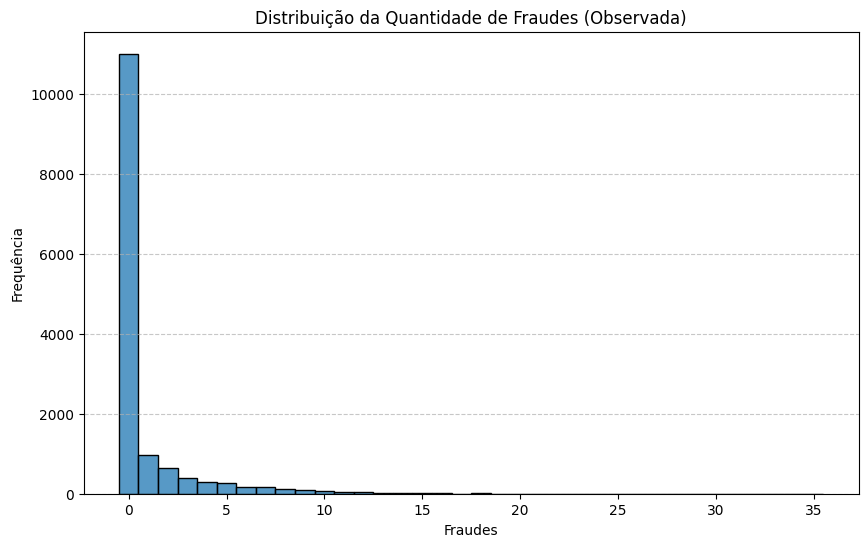

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 1.063733
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.056997
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


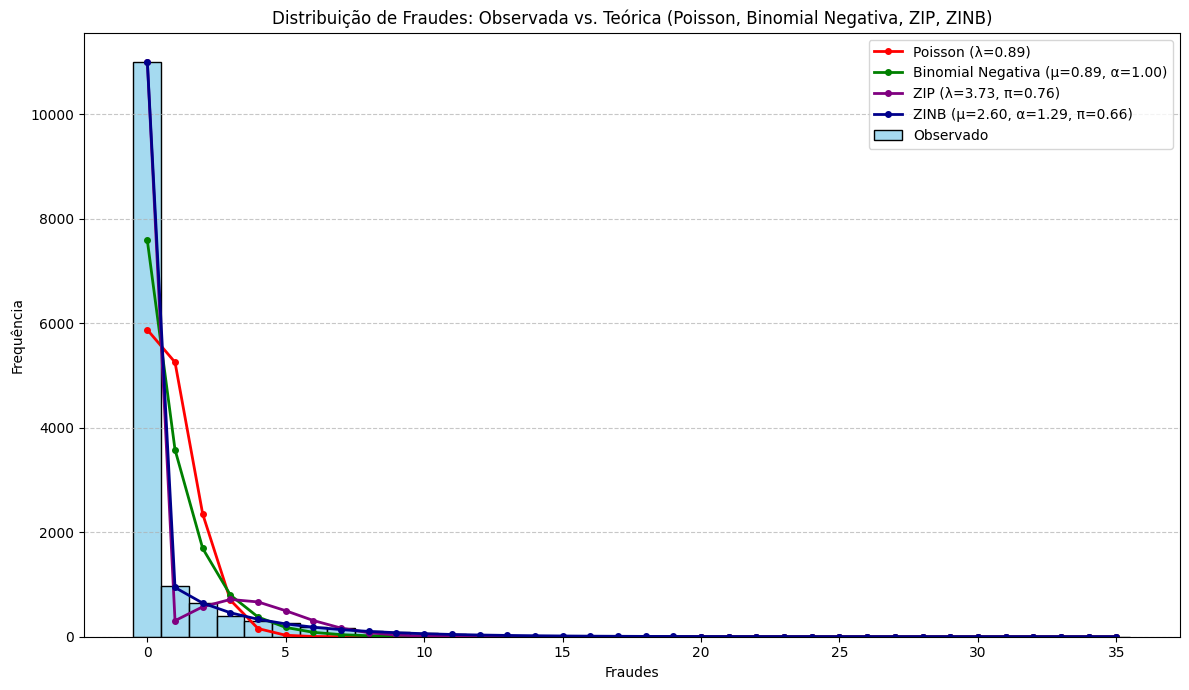

In [12]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

#### Comparação estatistica entre modelos

In [13]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Plotar a comparação entre modelos atraves do LogLik

In [14]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plotar os resíduos do modelo

In [15]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

#### Test de Vuong para Inflação de Zeros

In [16]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Algoritmo Stepwise para modelos Zero Inflated

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, check_X_y
from sklearn.exceptions import NotFittedError
import warnings
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm


class SimpleStepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor stepwise simplificado para modelos Zero-Inflated com validação de convergência.

    Esta versão simplificada foca em:
    - Seleção stepwise eficiente
    - Validação rigorosa de convergência do modelo
    - Critérios de parada inteligentes
    - Código limpo e manutenível

    Principais melhorias:
    - Validação de convergência em cada iteração
    - Detecção automática de instabilidade numérica
    - Early stopping baseado em múltiplos critérios
    - Código 10x mais simples que a versão original
    """

    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-6,
                 convergence_patience=3,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str]) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(
                    maxiter=self.max_fit_iterations,
                    method=self.method,
                    cov_type=self.cov_type,
                    disp=False,
                    full_output=True  # Para obter informações detalhadas de convergência
                )

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str]) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # Inicialização
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y)
        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"⚠️  Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"✅ Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

#### Algoritmo Complementar para Random Feature Selector

In [18]:
import numpy as np
from sklearn.base import BaseEstimator, clone

class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn  # agora o usuário fornece essa função
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if score > best_score:
                best_score = score
                self.best_estimator_ = model
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.

---

### Utilização

O modelo de regressão de Poisson é indicado para modelar variáveis discretas de contagem com:

- Distribuição assimétrica à direita;
- Muitos zeros e poucos valores altos;
- Relação entre média e variância próximas (equidispersão).



In [19]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

Média  Variância
0  0.894103   5.224894

Há indícios de superdispersão.

In [20]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ median_amount + max_amount + min_current_age + median_current_age + max_current_age + min_per_capita_income + median_per_capita_income + max_per_capita_income + min_total_debt + median_total_debt + max_total_debt + min_credit_score + median_credit_score + max_credit_score + min_num_credit_cards + median_num_credit_cards + max_num_credit_cards + median_credit_limit + max_credit_limit + target_city_0 + target_city_1 + target_description_0 + target_description_2 + previous_frauds'

In [21]:
result_tests = {}
for column in X.drop(columns='frauds').columns:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [22]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23344.
Date:                Wed, 06 Aug 2025   Deviance:                       36869.
Time:                        17:02:38   Pearson chi2:                 7.59e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4518
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8098      0.014    -56.670      0.000      -0.838      -0.782
previous_frauds     1.6713      0.018     91.993      0.000       1.636       1.707
===================================================================================
"""

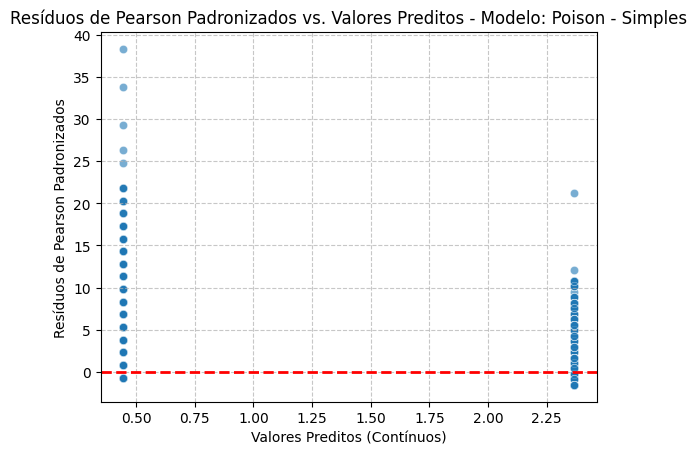

In [23]:
overdisp_plot(modelo_poison_simple, 'Poison - Simples')

Os residuos apresentam um padrão de dispersão centralizados em cada valor predito, evidencia também que a dispersão entre os valores é muito grande. Essa variância não constante é evidencia técnica de superdispersão.

In [24]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson(), error='ignore').fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14338
Model Family:                 Poisson   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17534.
Date:                Wed, 06 Aug 2025   Deviance:                       25249.
Time:                        17:02:39   Pearson chi2:                 8.80e+06
No. Iterations:                    17   Pseudo R-squ. (CS):             0.7559
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  626.6640     20.828     30.088      0.000     585.843     667.485
median_amount               -0.0629      0.002    -38.566      0.000      -0.066      -0.060
max_amount                   0.0002   1.95e-05     11.863      0.000       0.000       0.000
min_current_age             -0.1477      0.006    -24.746      0.000      -0.159      -0.136
median_current_age           0.1280      0.016      8.000      0.000       0.097       0.159
max_current_age              0.0407      0.006      6.784      0.000       0.029       0.052
min_per_capita_income    -4.166e-05   6.07e-06     -6.865      0.000   -5.36e-05   -2.98e-05
median_per_capita_income     0.0002   2.83e-05      8.301      0.000       0.000       0.000
max_per_capita_income    -3.525e-07   3.55e-07     -0.993      0.321   -1.05e-06    3.43e-07
min_total_debt               0.0004   7.29e-05      5.905      0.000       0.000       0.001
median_total_debt         1.812e-06   5.55e-06      0.326      0.744   -9.07e-06    1.27e-05
max_total_debt            2.383e-06   1.57e-07     15.162      0.000    2.07e-06    2.69e-06
min_credit_score             0.0018      0.001      1.415      0.157      -0.001       0.004
median_credit_score          0.0112      0.004      3.191      0.001       0.004       0.018
max_credit_score             0.0126      0.010      1.309      0.191      -0.006       0.031
min_num_credit_cards        -0.0310      1.144     -0.027      0.978      -2.273       2.211
median_num_credit_cards      0.2287      0.171      1.340      0.180      -0.106       0.563
max_num_credit_cards         0.2947      0.026     11.276      0.000       0.244       0.346
median_credit_limit         -0.0002   2.48e-05     -7.374      0.000      -0.000      -0.000
max_credit_limit          2.803e-06   4.21e-07      6.653      0.000    1.98e-06    3.63e-06
target_city_0             -209.6731      5.989    -35.008      0.000    -221.412    -197.934
target_city_1              111.0676     30.182      3.680      0.000      51.912     170.223
target_description_0      -449.2634     18.144    -24.760      0.000    -484.826    -413.701
target_description_2        31.0093     33.321      0.931      0.352     -34.299      96.318
previous_frauds              1.9258      0.020     95.184      0.000       1.886       1.965
============================================================================================
"""

In [25]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.006      
Dependent Variable:     ystar            AIC:                         125716.0852
Date:                   2025-08-06 17:02 BIC:                         125723.6576
No. Observations:       14363            Log-Likelihood:              -62857.    
Df Model:               1                F-statistic:                 82.36      
Df Residuals:           14362            Prob (F-statistic):          1.28e-19   
R-squared (uncentered): 0.006            Scale:                       370.49     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.8380         0.0923       9.0755       0.0000       0.6570    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

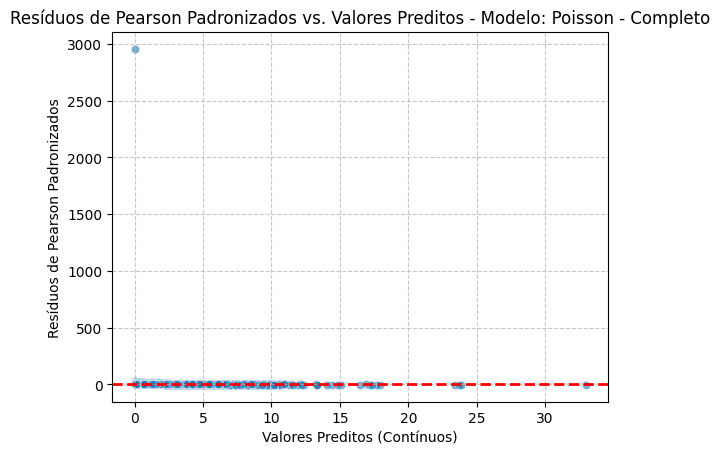

In [26]:
overdisp_plot(modelo_poison_complete, 'Poisson - Completo')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

In [27]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_capita_income') + Q('min_total_debt') + Q('median_total_debt') + Q('max_total_debt') + Q('min_credit_score') + Q('median_credit_score') + Q('max_credit_score') + Q('min_num_credit_cards') + Q('median_num_credit_cards') + Q('max_num_credit_cards') + Q('median_credit_limit') + Q('max_credit_limit') + Q('target_city_0') + Q('target_city_1') + Q('target_description_0') + Q('target_description_2') + Q('previous_frauds')

 Family type...: 
 Poisson

 Discarding atribute "Q('min_num_credit_cards')" with p-value equal to 0.9784051518324296 

Estimating model...: 
 frauds ~ Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_capita_

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14345
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17538.
Date:                Wed, 06 Aug 2025   Deviance:                       25257.
Time:                        17:02:44   Pearson chi2:                 6.54e+07
No. Iterations:                    16   Pseudo R-squ. (CS):             0.7557
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       649.2205     16.415     39.550      0.000     617.047     681.394
Q('median_amount')               -0.0637      0.002    -41.393      0.000      -0.067      -0.061
Q('max_amount')                   0.0002   1.92e-05     11.888      0.000       0.000       0.000
Q('min_current_age')             -0.1464      0.006    -24.865      0.000      -0.158      -0.135
Q('median_current_age')           0.1332      0.013      9.934      0.000       0.107       0.160
Q('max_current_age')              0.0405      0.006      6.756      0.000       0.029       0.052
Q('min_per_capita_income')    -4.053e-05   5.89e-06     -6.884      0.000   -5.21e-05    -2.9e-05
Q('median_per_capita_income')     0.0002   2.54e-05      8.972      0.000       0.000       0.000
Q('min_total_debt')               0.0004   2.71e-05     14.157      0.000       0.000       0.000
Q('max_total_debt')            2.351e-06   1.53e-07     15.331      0.000    2.05e-06    2.65e-06
Q('median_credit_score')          0.0129      0.003      3.884      0.000       0.006       0.019
Q('max_num_credit_cards')         0.2913      0.026     11.179      0.000       0.240       0.342
Q('median_credit_limit')         -0.0002   2.44e-05     -7.138      0.000      -0.000      -0.000
Q('max_credit_limit')          2.617e-06   4.01e-07      6.527      0.000    1.83e-06     3.4e-06
Q('target_city_0')             -211.5465      5.879    -35.984      0.000    -223.069    -200.024
Q('target_city_1')              113.8097     29.897      3.807      0.000      55.213     172.406
Q('target_description_0')      -458.8244     15.055    -30.476      0.000    -488.332    -429.317
Q('previous_frauds')              1.9238      0.020     95.842      0.000       1.884       1.963
=================================================================================================
"""

In [28]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.006      
Dependent Variable:     ystar            AIC:                         125860.9138
Date:                   2025-08-06 17:02 BIC:                         125868.4862
No. Observations:       14363            Log-Likelihood:              -62929.    
Df Model:               1                F-statistic:                 81.60      
Df Residuals:           14362            Prob (F-statistic):          1.87e-19   
R-squared (uncentered): 0.006            Scale:                       374.24     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.8390         0.0929       9.0334       0.0000       0.6569    

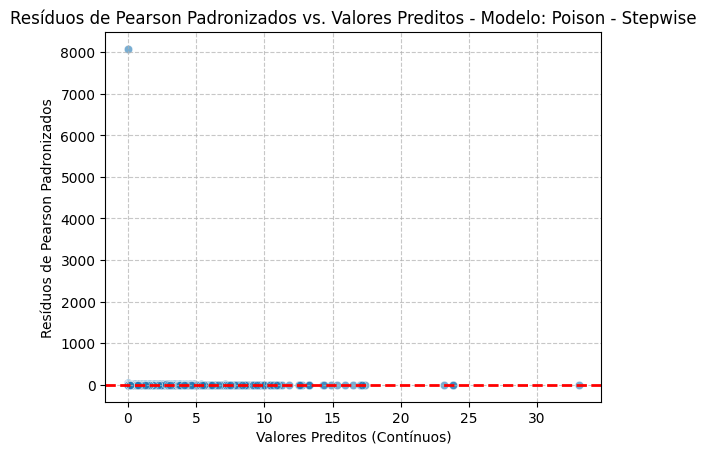

In [29]:
overdisp_plot(modelo_poisson_stepswise, 'Poison - Stepwise')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

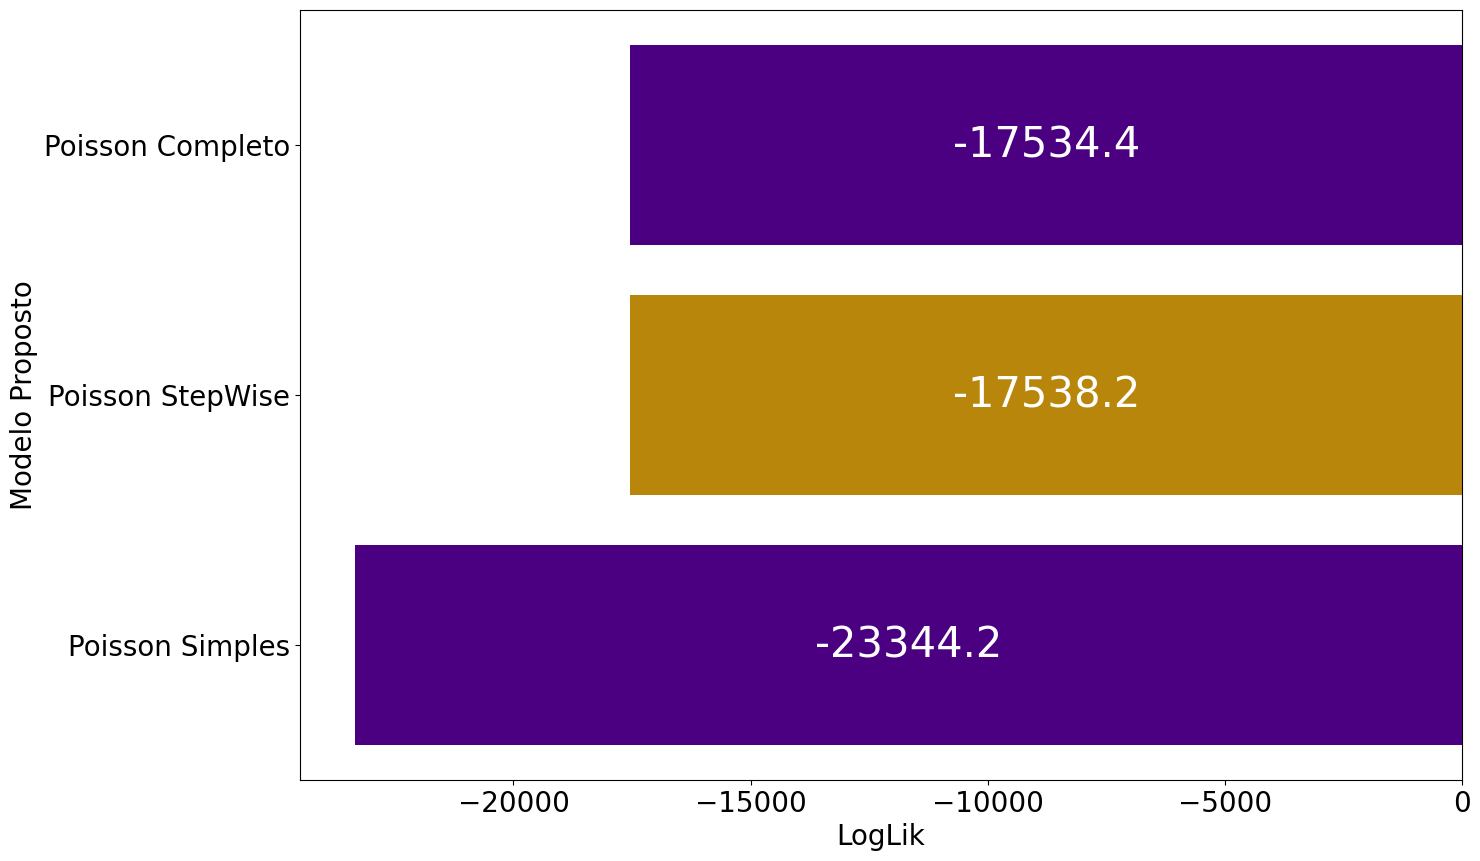

In [30]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida, conforme discutido no capítulo "Modelos de Regressão para Dados de Contagem" do manual.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.

---

### Quando Utilizar

- Dados de contagem com variância > média.
- Cenários onde o modelo de Poisson apresenta sobredispersão detectada via testes estatísticos.
- Alternativa robusta ao Poisson, sem necessidade de recorrer a modelos com inflação de zeros ou estruturas mais complexas.

---

**Nota:** A orientação para uso e interpretação desses modelos, incluindo verificação de sobredispersão, seleção de variáveis e diagnóstico de modelo, segue os princípios estabelecidos no capítulo 14 do manual.


In [31]:
result_tests = {}
for column in X.drop(columns=['frauds'], errors='ignore').columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [32]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16694.
Date:                Wed, 06 Aug 2025   Deviance:                       18553.
Time:                        17:02:46   Pearson chi2:                 4.60e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2556
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8098      0.017    -47.144      0.000      -0.843      -0.776
previous_frauds     1.6713      0.027     62.337      0.000       1.619       1.724
===================================================================================
"""

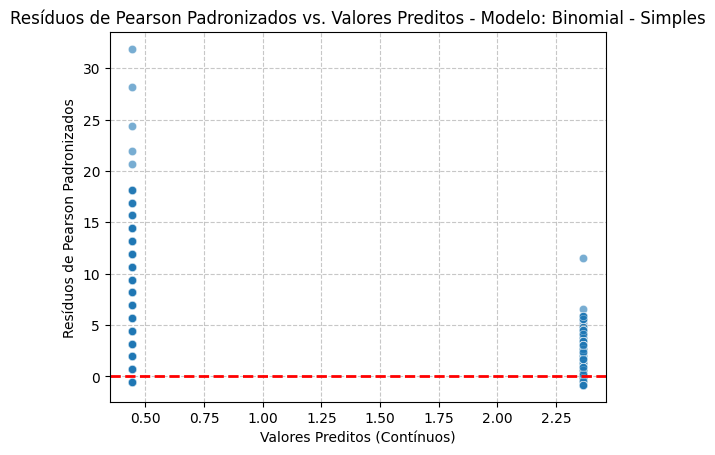

In [33]:
overdisp_plot(modelo_binomialneg_simples, 'Binomial - Simples')

Os residuos apresentam um padrão de dispersão centralizados em cada valor predito, evidencia também que a dispersão entre os valores é muito grande. Essa variância não constante é evidencia técnica de superdispersão.

In [34]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14338
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13827.
Date:                Wed, 06 Aug 2025   Deviance:                       12819.
Time:                        17:02:48   Pearson chi2:                 3.78e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5007
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1048.1152     40.475     25.896      0.000     968.786    1127.444
median_amount               -0.0729      0.002    -29.857      0.000      -0.078      -0.068
max_amount                   0.0003   3.57e-05      7.773      0.000       0.000       0.000
min_current_age             -0.1267      0.010    -12.895      0.000      -0.146      -0.107
median_current_age           0.1412      0.024      5.798      0.000       0.093       0.189
max_current_age              0.0372      0.008      4.495      0.000       0.021       0.053
min_per_capita_income     -3.42e-05   7.53e-06     -4.545      0.000    -4.9e-05   -1.95e-05
median_per_capita_income     0.0003   4.35e-05      6.918      0.000       0.000       0.000
max_per_capita_income    -3.842e-07   5.79e-07     -0.663      0.507   -1.52e-06    7.51e-07
min_total_debt               0.0008   8.88e-05      9.108      0.000       0.001       0.001
median_total_debt         9.238e-06   8.48e-06      1.090      0.276   -7.38e-06    2.59e-05
max_total_debt            1.753e-06   2.32e-07      7.569      0.000     1.3e-06    2.21e-06
min_credit_score             0.0049      0.002      2.937      0.003       0.002       0.008
median_credit_score          0.0105      0.005      1.980      0.048       0.000       0.021
max_credit_score             0.0001      0.010      0.013      0.990      -0.019       0.019
min_num_credit_cards        -1.1135      1.759     -0.633      0.527      -4.561       2.334
median_num_credit_cards      0.1969      0.259      0.759      0.448      -0.311       0.705
max_num_credit_cards         0.3381      0.039      8.559      0.000       0.261       0.415
median_credit_limit         -0.0002    3.8e-05     -5.520      0.000      -0.000      -0.000
max_credit_limit          2.741e-06   6.79e-07      4.040      0.000    1.41e-06    4.07e-06
target_city_0             -511.2004     19.198    -26.628      0.000    -548.827    -473.574
target_city_1               52.2917     71.632      0.730      0.465     -88.105     192.688
target_description_0      -560.6309     33.643    -16.664      0.000    -626.569    -494.693
target_description_2        49.1406     64.004      0.768      0.443     -76.305     174.586
previous_frauds              1.9958      0.033     59.614      0.000       1.930       2.061
============================================================================================
"""

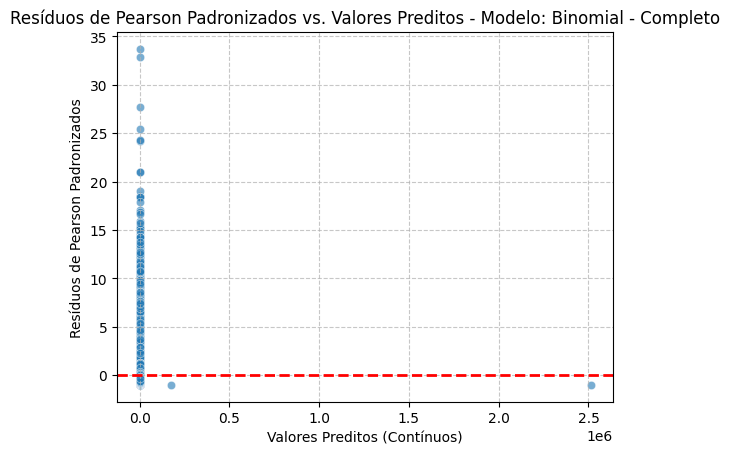

In [35]:
overdisp_plot(modelo_binomialneg_completo, 'Binomial - Completo')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

In [36]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_capita_income') + Q('min_total_debt') + Q('median_total_debt') + Q('max_total_debt') + Q('min_credit_score') + Q('median_credit_score') + Q('max_credit_score') + Q('min_num_credit_cards') + Q('median_num_credit_cards') + Q('max_num_credit_cards') + Q('median_credit_limit') + Q('max_credit_limit') + Q('target_city_0') + Q('target_city_1') + Q('target_description_0') + Q('target_description_2') + Q('previous_frauds')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('max_credit_score')" with p-value equal to 0.9900208557897279 

Estimating model...: 
 frauds ~ Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_c

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14345
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13829.
Date:                Wed, 06 Aug 2025   Deviance:                       12823.
Time:                        17:03:01   Pearson chi2:                 3.82e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5005
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1062.1063     34.812     30.510      0.000     993.877    1130.336
Q('median_amount')               -0.0740      0.002    -31.537      0.000      -0.079      -0.069
Q('max_amount')                   0.0003   3.54e-05      7.695      0.000       0.000       0.000
Q('min_current_age')             -0.1248      0.010    -12.798      0.000      -0.144      -0.106
Q('median_current_age')           0.1364      0.021      6.630      0.000       0.096       0.177
Q('max_current_age')              0.0370      0.008      4.477      0.000       0.021       0.053
Q('min_per_capita_income')    -3.164e-05   7.33e-06     -4.318      0.000    -4.6e-05   -1.73e-05
Q('median_per_capita_income')     0.0003    3.9e-05      7.871      0.000       0.000       0.000
Q('min_total_debt')               0.0008   3.12e-05     25.707      0.000       0.001       0.001
Q('max_total_debt')            1.758e-06   2.27e-07      7.747      0.000    1.31e-06     2.2e-06
Q('min_credit_score')             0.0051      0.002      3.096      0.002       0.002       0.008
Q('median_credit_score')          0.0106      0.005      2.076      0.038       0.001       0.021
Q('max_num_credit_cards')         0.3381      0.039      8.577      0.000       0.261       0.415
Q('median_credit_limit')         -0.0002   3.75e-05     -5.320      0.000      -0.000      -0.000
Q('max_credit_limit')          2.526e-06   6.39e-07      3.952      0.000    1.27e-06    3.78e-06
Q('target_city_0')             -515.8546     18.578    -27.767      0.000    -552.267    -479.442
Q('target_description_0')      -569.9344     28.671    -19.878      0.000    -626.129    -513.740
Q('previous_frauds')              1.9914      0.033     60.031      0.000       1.926       2.056
=================================================================================================
"""

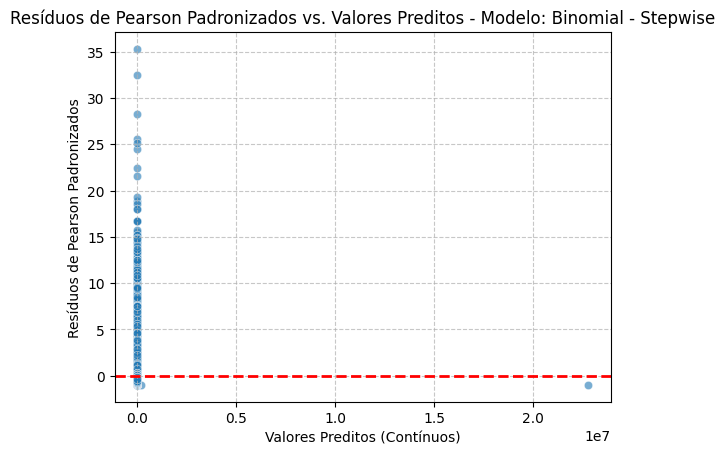

In [37]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial - Stepwise')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

In [38]:
lrtest([modelo_binomialneg_completo, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -4.35
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


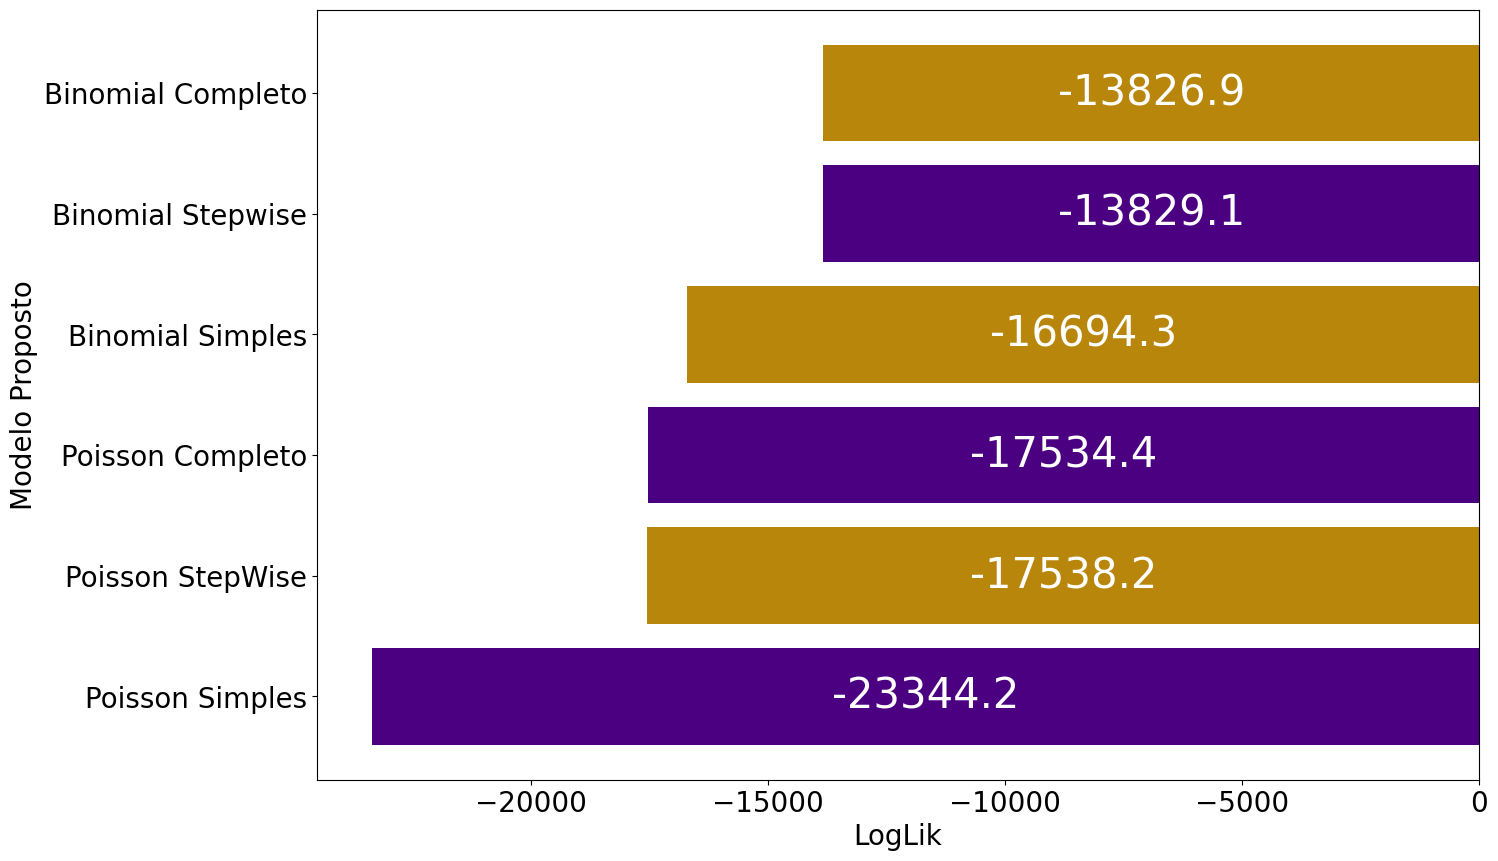

In [39]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.


In [40]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

median_amount  max_amount  min_current_age  median_current_age  \
0       3.704337    5.602930         3.433987            4.018701   
1       3.593181    7.051518         3.367296            4.035644   
2       3.993524    7.178324         3.367296            4.049284   
3       3.971532    6.541463         3.433987            4.032765   
4       4.359699    6.739289         3.496508            4.031286   

   max_current_age  min_per_capita_income  median_per_capita_income  \
0         4.624973               0.000000                 10.019666   
1         4.624973               0.000000                 10.088966   
2         4.605170               0.000000                 10.096161   
3         4.595120               0.000000                 10.111789   
4         4.510860               9.219498                 10.039118   

   max_per_capita_income  min_total_debt  median_total_debt  ...  \
0              10.921667             0.0          10.972032  ...   
1              11.830863             0.0          10.945473  ...   
2              12.002401             0.0          10.902716  ...   
3              11.830863             0.0          10.896100  ...   
4              10.890740             0.0          10.957843  ...   

   min_num_credit_cards  median_num_credit_cards  max_num_credit_cards  \
0              0.693147                 1.598775              2.197225   
1              0.693147                 1.605247              2.302585   
2              0.693147                 1.585391              2.302585   
3              0.693147                 1.575105              2.197225   
4              0.693147                 1.589419              2.197225   

   median_credit_limit  max_credit_limit  target_city_0  target_city_1  \
0             9.684469         11.243005       0.693147            0.0   
1             9.620037         11.158933       0.693147            0.0   
2             9.664143         11.741844       0.693147            0.0   
3             9.612056         11.478727       0.693147            0.0   
4             9.580258         10.955969       0.693147            0.0   

   target_description_0  target_description_2  previous_frauds  
0              0.693147                   0.0         0.000000  
1              0.693147                   0.0         0.000000  
2              0.693147                   0.0         0.000000  
3              0.693147                   0.0         0.000000  
4              0.693147                   0.0         0.693147  

[5 rows x 24 columns]

In [41]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [42]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped.drop(columns=['frauds']))

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.drop(columns=['frauds']).columns)
X_scaler.head()

median_amount  max_amount  min_current_age  median_current_age  \
0      -0.899793   -1.383952         2.176504            0.631691   
1      -1.165274    0.665779         1.168812            1.495333   
2      -0.053538    1.027979         1.168812            2.201350   
3      -0.126839   -0.404599         2.176504            1.347536   
4       1.436620   -0.052702         3.184196            1.271822   

   max_current_age  min_per_capita_income  median_per_capita_income  \
0         0.846917              -0.456245                 -1.891589   
1         0.846917              -0.456245                  0.419399   
2         0.217801              -0.456245                  0.668627   
3        -0.096757              -0.456245                  1.216220   
4        -2.613220               2.233191                 -1.258992   

   max_per_capita_income  min_total_debt  median_total_debt  ...  \
0              -1.604014       -0.017755           0.139048  ...   
1               0.487581       -0.017755          -0.396071  ...   
2               1.143023       -0.017755          -1.228235  ...   
3               0.487581       -0.017755          -1.353866  ...   
4              -1.646985       -0.017755          -0.148610  ...   

   min_num_credit_cards  median_num_credit_cards  max_num_credit_cards  \
0             -0.020033                 0.977937             -0.964473   
1             -0.020033                 1.323309              0.957381   
2             -0.020033                 0.270757              0.957381   
3             -0.020033                -0.266343             -0.964473   
4             -0.020033                 0.482580             -0.964473   

   median_credit_limit  max_credit_limit  target_city_0  target_city_1  \
0             0.886454         -0.760066       0.078911          -0.03   
1            -0.615740         -0.942568       0.078911          -0.03   
2             0.402064          0.703864       0.078911          -0.03   
3            -0.795174         -0.158426       0.078911          -0.03   
4            -1.495999         -1.324797       0.078911          -0.03   

   target_description_0  target_description_2  previous_frauds  
0              0.136664             -0.099345        -0.552282  
1              0.136664             -0.099345        -0.552282  
2              0.136664             -0.099345        -0.552282  
3              0.136664             -0.099345        -0.552282  
4              0.136664             -0.099345         1.810669  

[5 rows x 24 columns]

In [43]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
  result_tests[column] = modelo_zip_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [44]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [45]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14361
Method:                            MLE   Df Model:                            1
Date:                 Wed, 06 Aug 2025   Pseudo R-squ.:                 0.07254
Time:                         17:03:07   Log-Likelihood:                -15512.
converged:                        True   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const               1.3018      0.023     57.160      0.000       1.257       1.346
inflate_previous_frauds    -0.8274      0.019    -43.635      0.000      -0.865      -0.790
const                       1.1905      0.012     97.990      0.000       1.167       1.214
previous_frauds             0.1496      0.008     18.315      0.000       0.134       0.166
===========================================================================================
"""

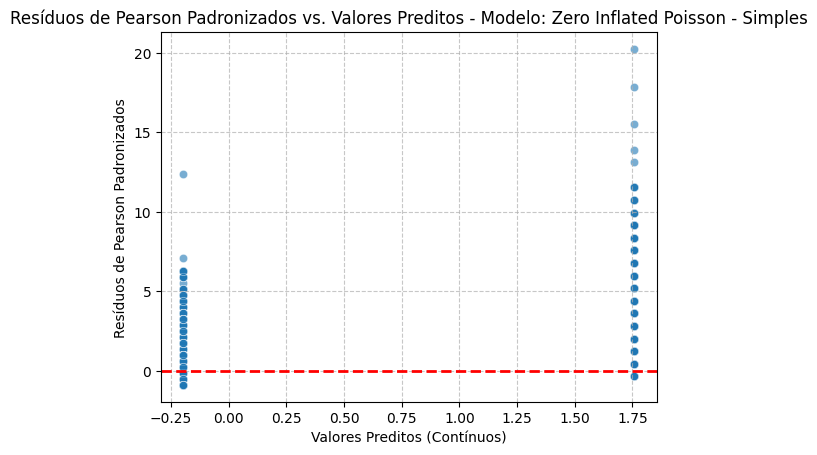

In [46]:
overdisp_plot(modelo_zip_simples, 'Zero Inflated Poisson - Simples')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão porém o modelo ZIP conseguiu identificar a quantidade de zeros ao contrário do modelo ZIP

In [47]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 1.625302
         Iterations 6
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -31.833
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [48]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [49]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14338
Method:                            MLE   Df Model:                           24
Date:                 Wed, 06 Aug 2025   Pseudo R-squ.:                  0.2053
Time:                         17:03:10   Log-Likelihood:                -13292.
converged:                       False   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
inflate_const                        1.3582      0.099     13.762      0.000       1.165       1.552
inflate_median_amount                1.1144      0.068     16.298      0.000       0.980       1.248
inflate_max_amount                  -0.0632      0.028     -2.242      0.025      -0.118      -0.008
inflate_min_current_age              0.1495      0.033      4.504      0.000       0.084       0.215
inflate_median_current_age          -0.1115      0.044     -2.512      0.012      -0.199      -0.024
inflate_max_current_age              0.0477      0.043      1.118      0.263      -0.036       0.131
inflate_min_per_capita_income        0.1450      0.045      3.236      0.001       0.057       0.233
inflate_median_per_capita_income    -0.1689      0.051     -3.330      0.001      -0.268      -0.069
inflate_max_per_capita_income        0.0331      0.038      0.872      0.383      -0.041       0.108
inflate_min_total_debt              -0.5010      5.600     -0.089      0.929     -11.477      10.475
inflate_median_total_debt           -0.0192      0.040     -0.476      0.634      -0.099       0.060
inflate_max_total_debt              -0.2064      0.041     -5.012      0.000      -0.287      -0.126
inflate_min_credit_score            -0.1417      0.043     -3.312      0.001      -0.226      -0.058
inflate_median_credit_score          0.0227      0.036      0.639      0.523      -0.047       0.092
inflate_max_credit_score             0.4716      0.075      6.277      0.000       0.324       0.619
inflate_min_num_credit_cards        -0.2764      9.570     -0.029      0.977     -19.032      18.480
inflate_median_num_credit_cards     -0.0377      0.040     -0.940      0.347      -0.116       0.041
inflate_max_num_credit_cards        -0.1764      0.034     -5.172      0.000      -0.243      -0.110
inflate_median_credit_limit          0.1096      0.042      2.604      0.009       0.027       0.192
inflate_max_credit_limit            -0.0266      0.038     -0.703      0.482      -0.101       0.048
inflate_target_city_0                1.0543      0.163      6.464      0.000       0.735       1.374
inflate_target_city_1               -0.2941      0.270     -1.089      0.276      -0.823       0.235
inflate_target_description_0         0.3387      0.067      5.042      0.000       0.207       0.470
inflate_target_description_2         0.0185      0.040      0.462      0.644      -0.060       0.097
inflate_previous_frauds             -1.1127      0.027    -41.557      0.000      -1.165      -1.060
const                                0.6125      0.020     30.227      0.000       0.573       0.652
median_amount                       -0.4455      0.030    -14.964      0.000      -0.504      -0.387
max_amount                           0.0750      0.009      8.208      0.000       0.057       0.093
min_current_age                     -0.1483      0.013    -11.600      0.000      -0.173      -0.123


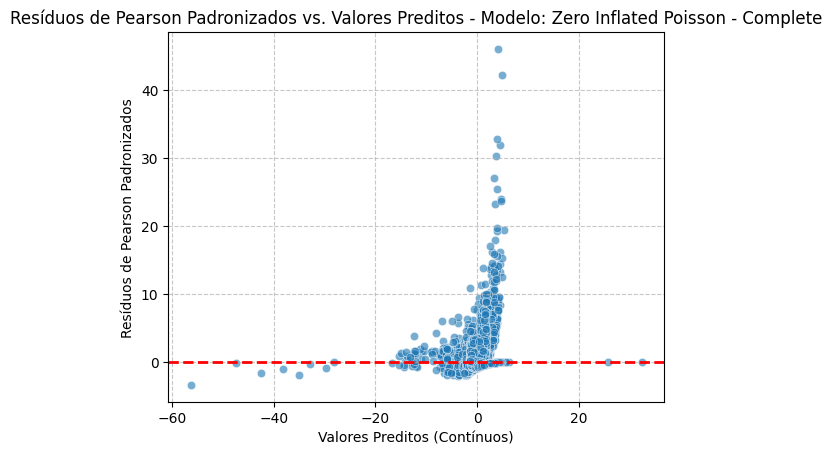

In [50]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson - Complete')

O modelo conseguiu identificar bem a questão de inflação de zeros mas não conseguiu lidar com a superdispersão dos dados para os outros targets com uma variancia muito alta.

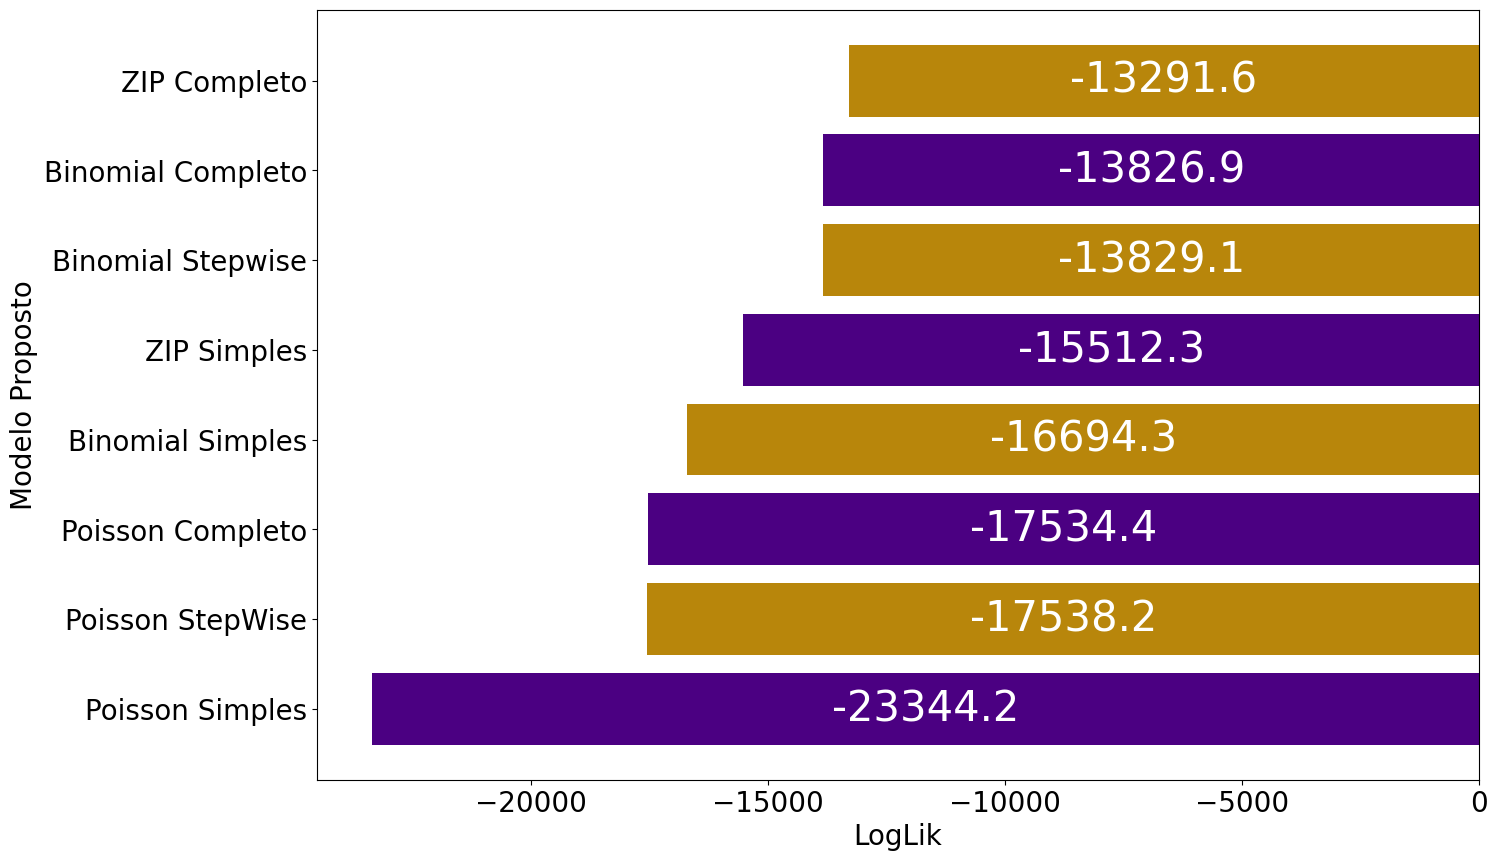

In [51]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [52]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='LLF',
    verbose=False,
)
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=42)
random_selector.fit(X_scaler, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=42,
                      scoring_fn=<function <lambda> at 0x7a9bc04ce0c0>)

In [53]:
modelo_zip_stepwise = random_selector.best_estimator_.final_model_

In [54]:
# modelo_zip_stepwise = step_wise.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14352
Method:                            MLE   Df Model:                           10
Date:                 Wed, 06 Aug 2025   Pseudo R-squ.:                  0.1795
Time:                         17:53:59   Log-Likelihood:                -13723.
converged:                       False   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
inflate_const                    1.3172      0.046     28.693      0.000       1.227       1.407
inflate_previous_frauds         -1.1758      0.027    -43.694      0.000      -1.229      -1.123
inflate_median_amount            1.2607      0.059     21.374      0.000       1.145       1.376
inflate_target_city_0            1.9771      0.444      4.456      0.000       1.107       2.847
inflate_target_description_0     0.2817      0.026     10.683      0.000       0.230       0.333
inflate_max_num_credit_cards    -0.2626      0.032     -8.285      0.000      -0.325      -0.200
inflate_max_credit_limit        -0.0853      0.032     -2.659      0.008      -0.148      -0.022
inflate_min_current_age          0.1127      0.029      3.912      0.000       0.056       0.169
inflate_min_credit_score        -0.1747      0.041     -4.261      0.000      -0.255      -0.094
const                            0.8338      0.016     50.543      0.000       0.801       0.866
max_total_debt                   0.3082      0.018     17.427      0.000       0.274       0.343
median_amount                   -0.1036      0.022     -4.761      0.000      -0.146      -0.061
target_city_0                   -0.0542      0.003    -17.204      0.000      -0.060      -0.048
target_description_0            -0.0875      0.005    -15.976      0.000      -0.098      -0.077
max_num_credit_cards             0.1206      0.014      8.428      0.000       0.093       0.149
max_credit_limit                 0.0989      0.014      7.183      0.000       0.072       0.126
min_per_capita_income           -0.2029      0.026     -7.670      0.000      -0.255      -0.151
median_credit_score              0.0956      0.015      6.573      0.000       0.067       0.124
min_current_age                 -0.0580      0.010     -5.644      0.000      -0.078      -0.038
min_credit_score                -0.0927      0.021     -4.344      0.000      -0.135      -0.051
================================================================================================
"""

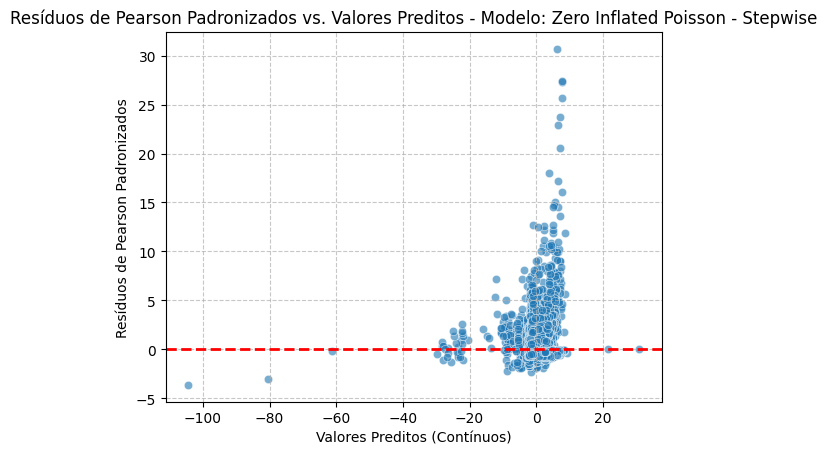

In [55]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson - Stepwise')

In [56]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -0.0
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


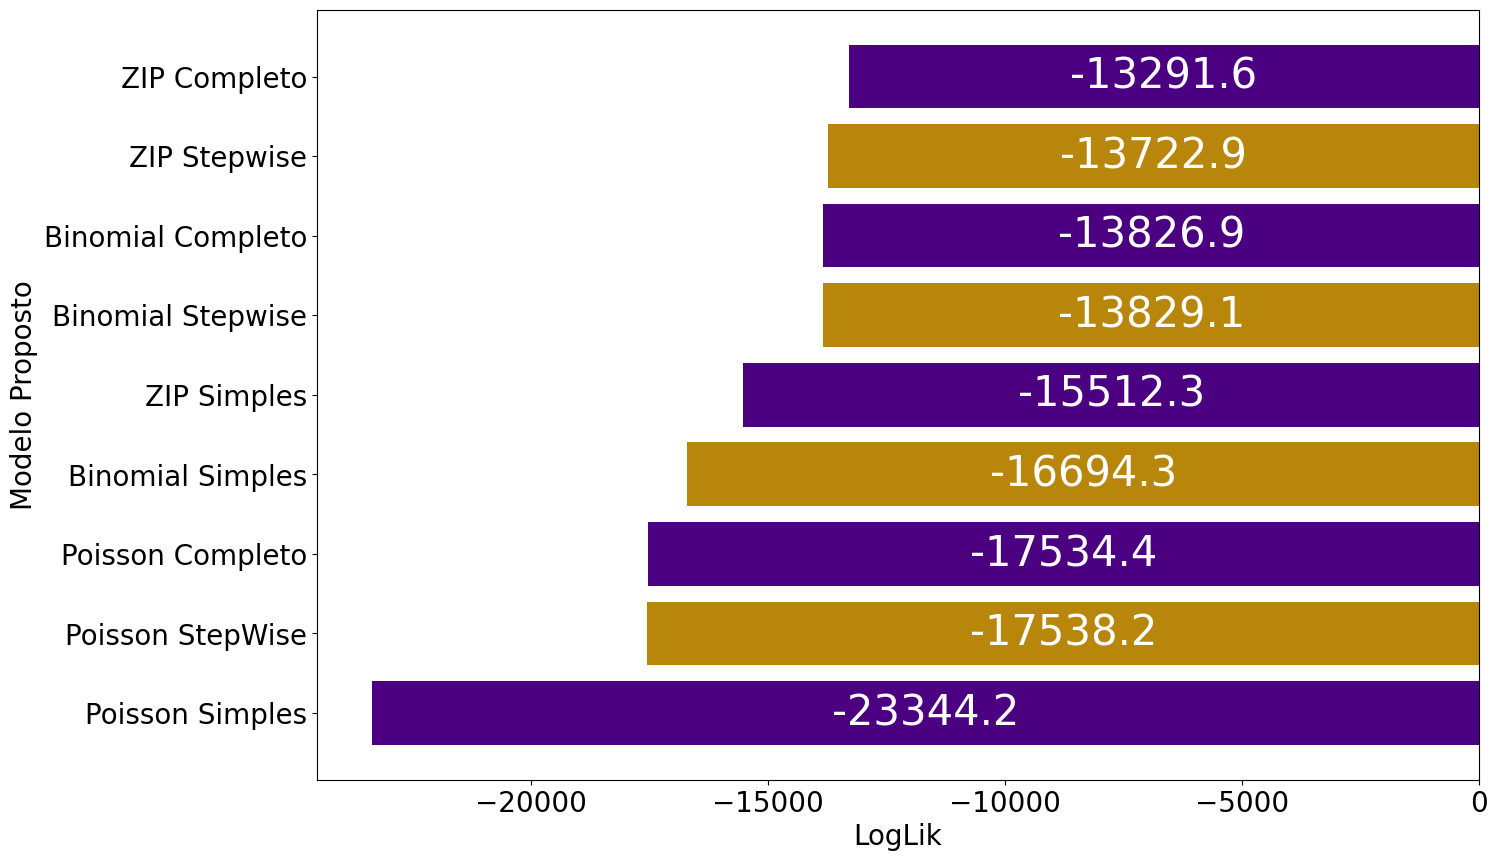

In [57]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf
      ]
})

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


In [58]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, cov_type='HC1').fit(disp=False)
  result_tests[column] = modelo_zbneg_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [59]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [60]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zinb_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14361
Method:                                      MLE   Df Model:                            1
Date:                           Wed, 06 Aug 2025   Pseudo R-squ.:                 0.06985
Time:                                   17:54:24   Log-Likelihood:                -14121.
converged:                                  True   LL-Null:                       -15182.
Covariance Type:                             HC1   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const              -3.3590      0.034    -97.780      0.000      -3.426      -3.292
inflate_previous_frauds    -7.7331      0.066   -116.890      0.000      -7.863      -7.603
const                       0.5384      0.033     16.339      0.000       0.474       0.603
previous_frauds             0.1785      0.019      9.239      0.000       0.141       0.216
alpha                       2.2401      0.077     29.123      0.000       2.089       2.391
===========================================================================================
"""

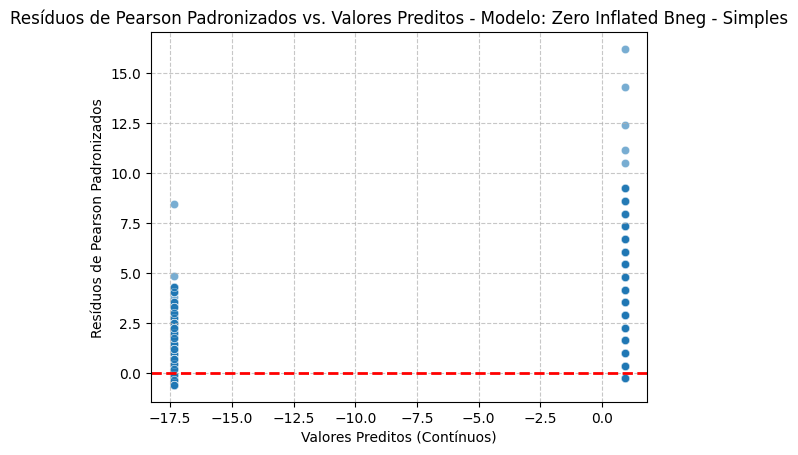

In [61]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Bneg - Simples')

In [62]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 1.023686
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -17.535
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [63]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [64]:
modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zinb_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14338
Method:                                      MLE   Df Model:                           24
Date:                           Wed, 06 Aug 2025   Pseudo R-squ.:                  0.1764
Time:                                   17:55:04   Log-Likelihood:                -12504.
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                             HC1   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
inflate_const                        0.1039      0.336      0.309      0.757      -0.555       0.762
inflate_median_amount                0.9995      0.266      3.762      0.000       0.479       1.520
inflate_max_amount                   0.0590      0.046      1.282      0.200      -0.031       0.149
inflate_min_current_age              0.1811      0.103      1.759      0.079      -0.021       0.383
inflate_median_current_age          -0.3017      0.115     -2.619      0.009      -0.528      -0.076
inflate_max_current_age             -0.1270      0.111     -1.148      0.251      -0.344       0.090
inflate_min_per_capita_income       -0.3477      0.137     -2.535      0.011      -0.617      -0.079
inflate_median_per_capita_income    -0.0563      0.094     -0.596      0.551      -0.241       0.129
inflate_max_per_capita_income        0.1824      0.059      3.076      0.002       0.066       0.299
inflate_min_total_debt              -0.3980     74.664     -0.005      0.996    -146.737     145.941
inflate_median_total_debt           -0.4561      0.115     -3.954      0.000      -0.682      -0.230
inflate_max_total_debt               0.2380      0.084      2.843      0.004       0.074       0.402
inflate_min_credit_score            -0.2520      0.091     -2.775      0.006      -0.430      -0.074
inflate_median_credit_score         -0.0497      0.084     -0.593      0.553      -0.214       0.115
inflate_max_credit_score             0.0549      0.309      0.178      0.859      -0.552       0.661
inflate_min_num_credit_cards         0.1128     57.023      0.002      0.998    -111.650     111.876
inflate_median_num_credit_cards     -0.1506      0.071     -2.122      0.034      -0.290      -0.012
inflate_max_num_credit_cards        -0.0752      0.067     -1.127      0.260      -0.206       0.056
inflate_median_credit_limit          0.1379      0.080      1.726      0.084      -0.019       0.294
inflate_max_credit_limit            -0.0160      0.060     -0.265      0.791      -0.134       0.102
inflate_target_city_0                1.0635      0.182      5.849      0.000       0.707       1.420
inflate_target_city_1               -0.2763      0.065     -4.279      0.000      -0.403      -0.150
inflate_target_description_0         0.6382      0.337      1.892      0.058      -0.023       1.299
inflate_target_description_2         0.1393      0.165      0.847      0.397      -0.183       0.462
inflate_previous_frauds             -1.9865      0.609     -3.263      0.001      -3.180      -0.793
const                                0.0420      0.090      0.466      0.641      -0.135       0.219
median_amount                       -0.6054      0.082     -7.361      0.000      -0.767      -0.444
max_amount                           0.1328      0.022      5.903      0.000       0.089       0.177
min_current

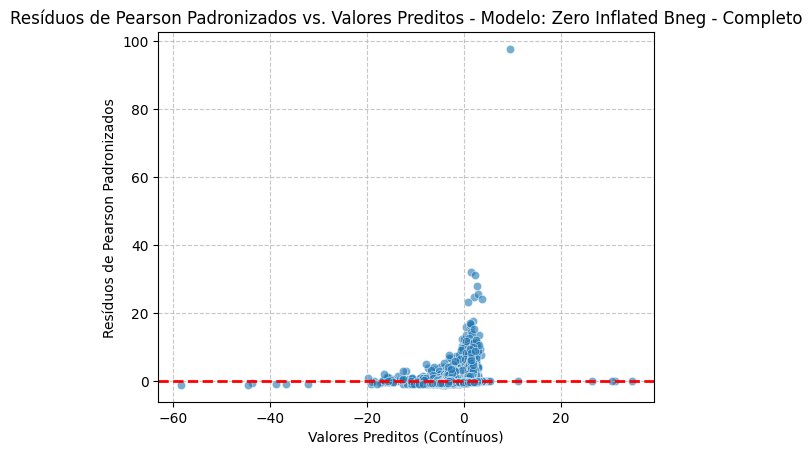

In [65]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Bneg - Completo')

In [66]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    verbose=False,
)
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=42)
random_selector.fit(X_scaler, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,p

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,p

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(model_type='ZINB',
                                                           selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=42,
                      scoring_fn=<function <lambda> at 0x7a9bb0306e80>)

In [67]:
modelo_zinb_stepwise = random_selector.best_estimator_.final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14351
Method:                                      MLE   Df Model:                           11
Date:                           Wed, 06 Aug 2025   Pseudo R-squ.:                  0.1234
Time:                                   20:01:59   Log-Likelihood:                -13308.
converged:                                  True   LL-Null:                       -15182.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
inflate_const                    -6.2416      0.708     -8.813      0.000      -7.630      -4.854
inflate_max_per_capita_income    -2.0390      0.433     -4.704      0.000      -2.889      -1.189
inflate_min_current_age          -1.6071      0.185     -8.692      0.000      -1.970      -1.245
inflate_median_credit_score       0.6369      0.145      4.393      0.000       0.353       0.921
inflate_max_credit_limit         -2.1911      0.483     -4.535      0.000      -3.138      -1.244
inflate_min_per_capita_income     0.2996      0.119      2.508      0.012       0.065       0.534
const                            -0.9026      0.026    -34.940      0.000      -0.953      -0.852
max_total_debt                    0.1720      0.029      5.937      0.000       0.115       0.229
previous_frauds                   0.8519      0.019     44.275      0.000       0.814       0.890
median_amount                    -1.2769      0.051    -25.119      0.000      -1.376      -1.177
target_city_0                    -0.2629      0.023    -11.625      0.000      -0.307      -0.219
target_description_0             -0.2408      0.020    -12.308      0.000      -0.279      -0.202
max_num_credit_cards              0.1949      0.026      7.537      0.000       0.144       0.246
min_current_age                  -0.1927      0.024     -8.160      0.000      -0.239      -0.146
min_total_debt                    0.9107      0.052     17.575      0.000       0.809       1.012
median_credit_score               0.1416      0.029      4.912      0.000       0.085       0.198
max_current_age                   0.1259      0.033      3.871      0.000       0.062       0.190
median_num_credit_cards           0.0958      0.029      3.249      0.001       0.038       0.154
alpha                             2.5410      0.082     31.177      0.000       2.381       2.701
=================================================================================================
"""

In [98]:
del random_selector, step_wise

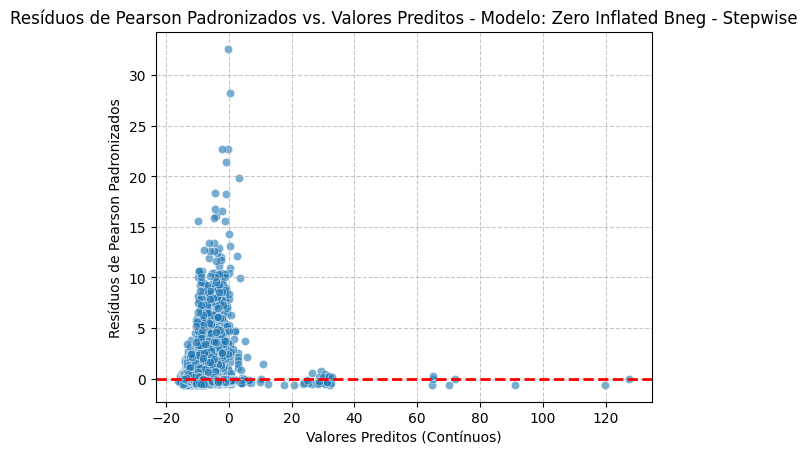

In [68]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Bneg - Stepwise')

## Métricas e Comparação

### Log Lik

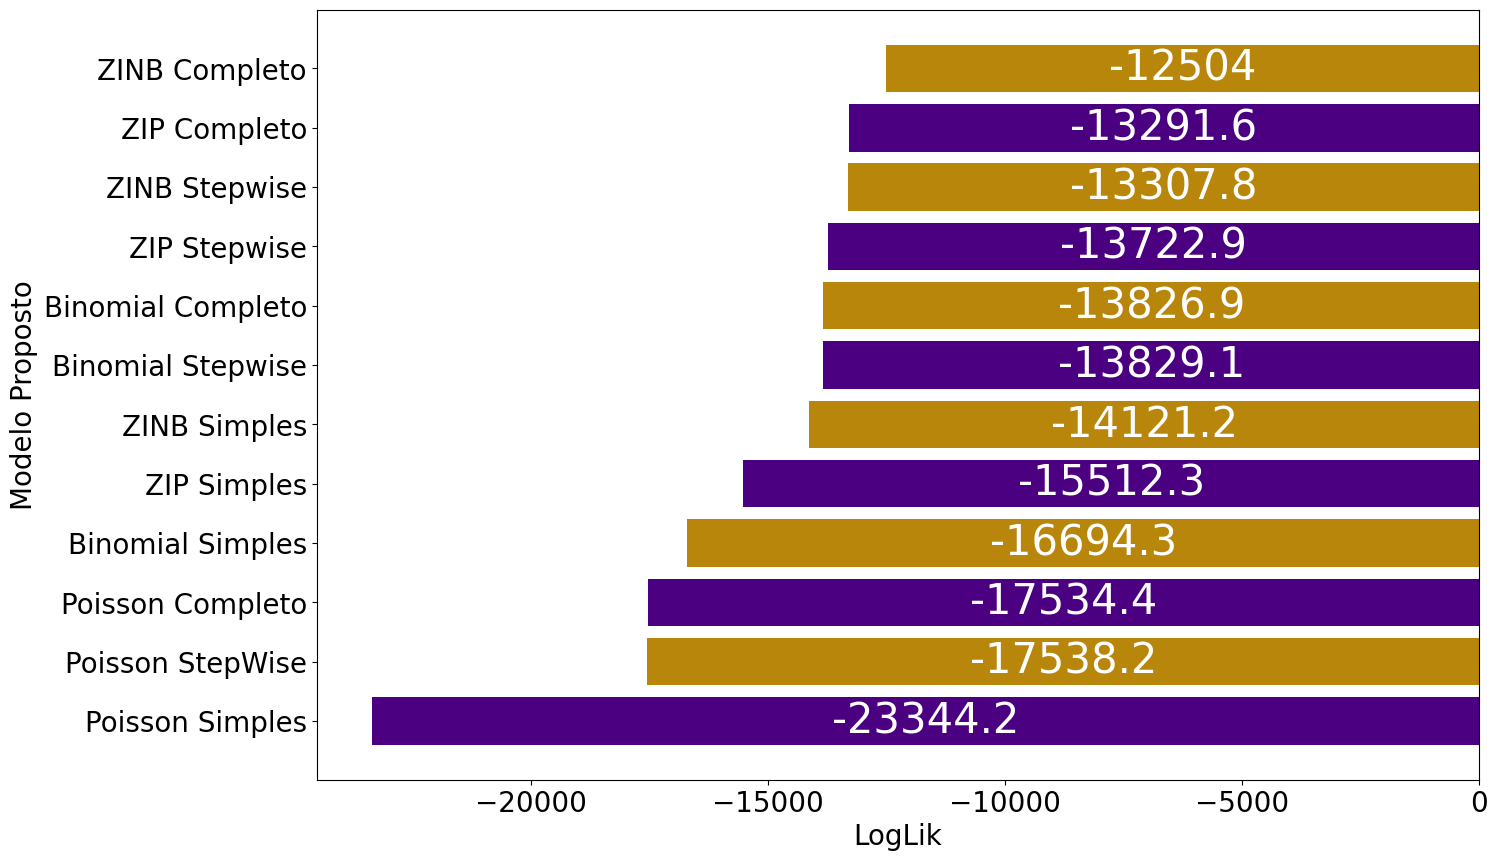

In [69]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_stepwise.llf
      ]
})

### Residuos padronizados x Valores preditos

In [70]:
titles = [
    'Poisson Simples',
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Simples',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Simples',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Simples',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_stepwise
]

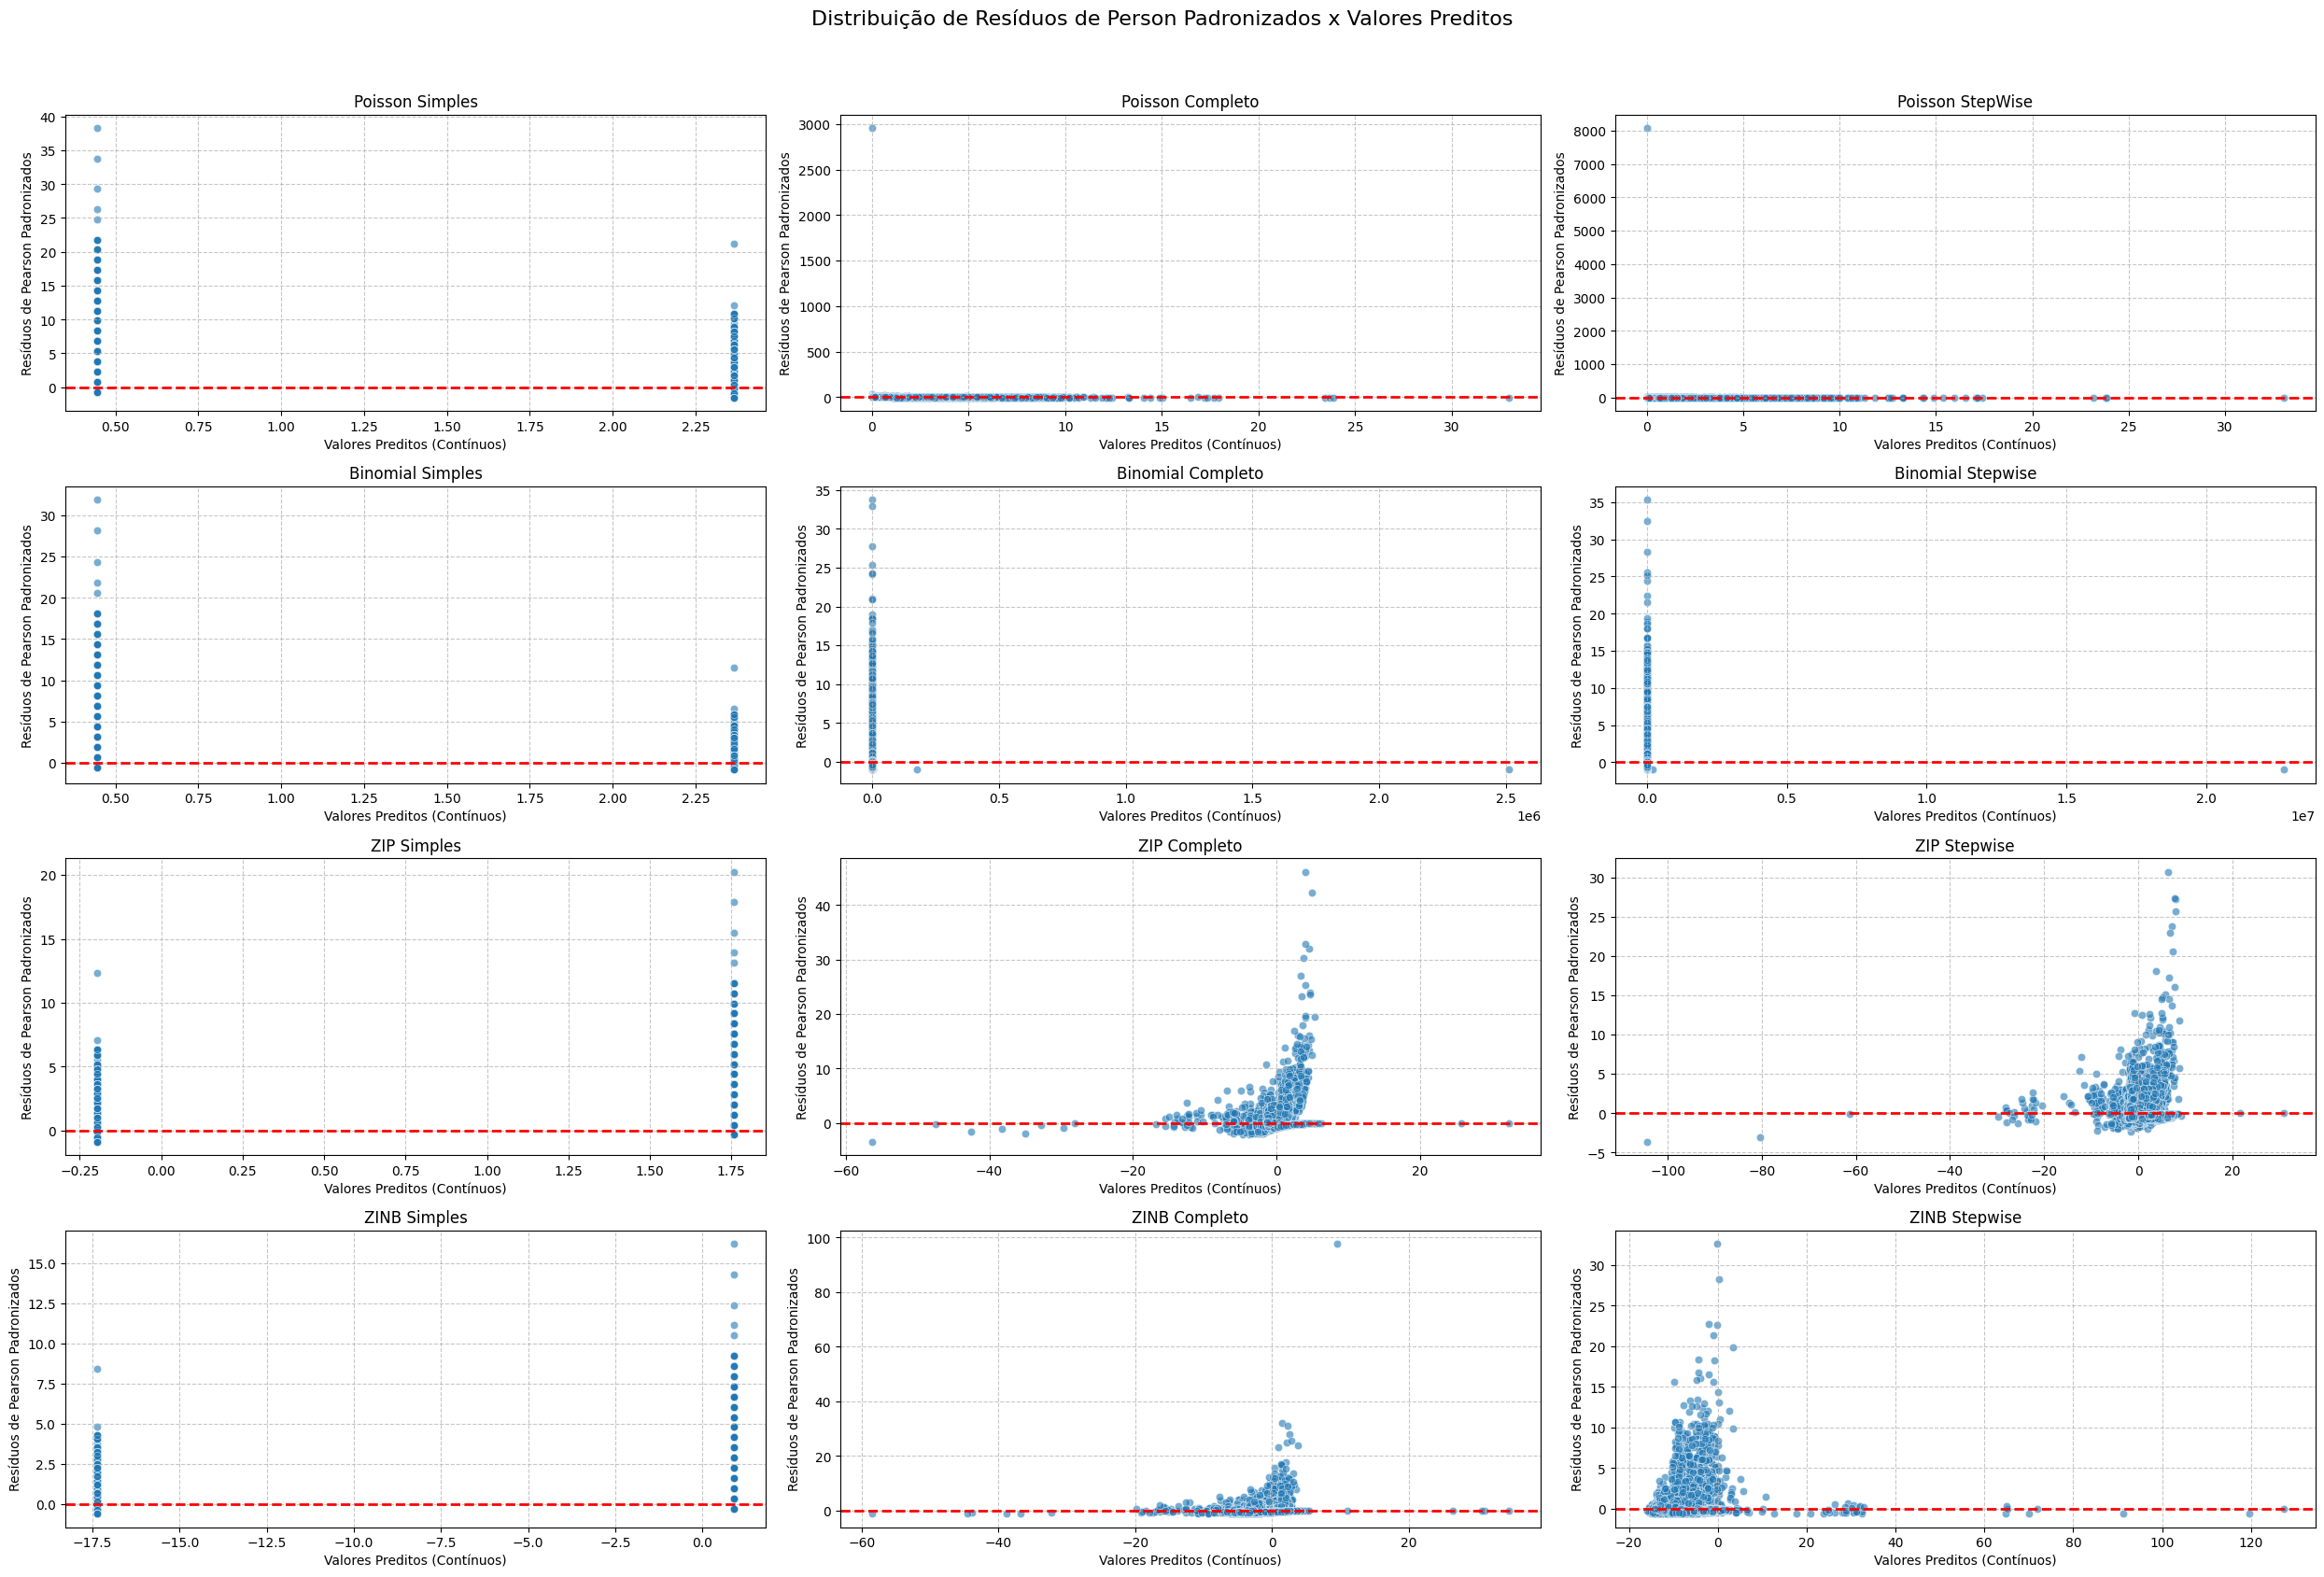

In [71]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 3, i + 1)
    overdisp_plot(model, titles[i], "{}")

plt.tight_layout()
plt.show()

In [72]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic, Converged=model.converged)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

### Tabela de Métricas

In [73]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by=['LLF', 'Converged'], ascending=False).reset_index(drop=True)

title           LLF            BIC           AIC  Converged  \
0       ZINB Completo -12504.015535   25496.224017  25110.031069      False   
1        ZIP Completo -13291.623485   27061.867508  26683.246971      False   
2       ZINB Stepwise -13307.784544   26797.444892  26653.569088       True   
3        ZIP Stepwise -13722.933713   27637.315640  27485.867426      False   
4   Binomial Completo -13826.920903 -124430.699489  27703.841806      False   
5   Binomial Stepwise -13829.094577 -124493.359016  27694.189154      False   
6        ZINB Simples -14121.189974   28290.242002  28252.379948       True   
7         ZIP Simples -15512.254192   31062.798027  31032.508384       True   
8    Binomial Simples -16694.331198 -118916.044346  33392.662397       True   
9    Poisson Completo -17534.379032 -112000.030268  35118.758064       True   
10   Poisson StepWise -17538.166423 -112059.462363  35112.332845       True   
11    Poisson Simples -23344.215151 -100600.523478  46692.430301       True   

    PseudoR2  
0   0.176373  
1   0.205313  
2   0.123429  
3   0.179525  
4   0.500680  
5   0.500529  
6   0.069851  
7   0.072544  
8   0.255640  
9   0.755866  
10  0.755738  
11  0.451758

### Comparação de Métricas entre modelos

In [74]:
df_metrics.query('Converged == True', inplace=True)

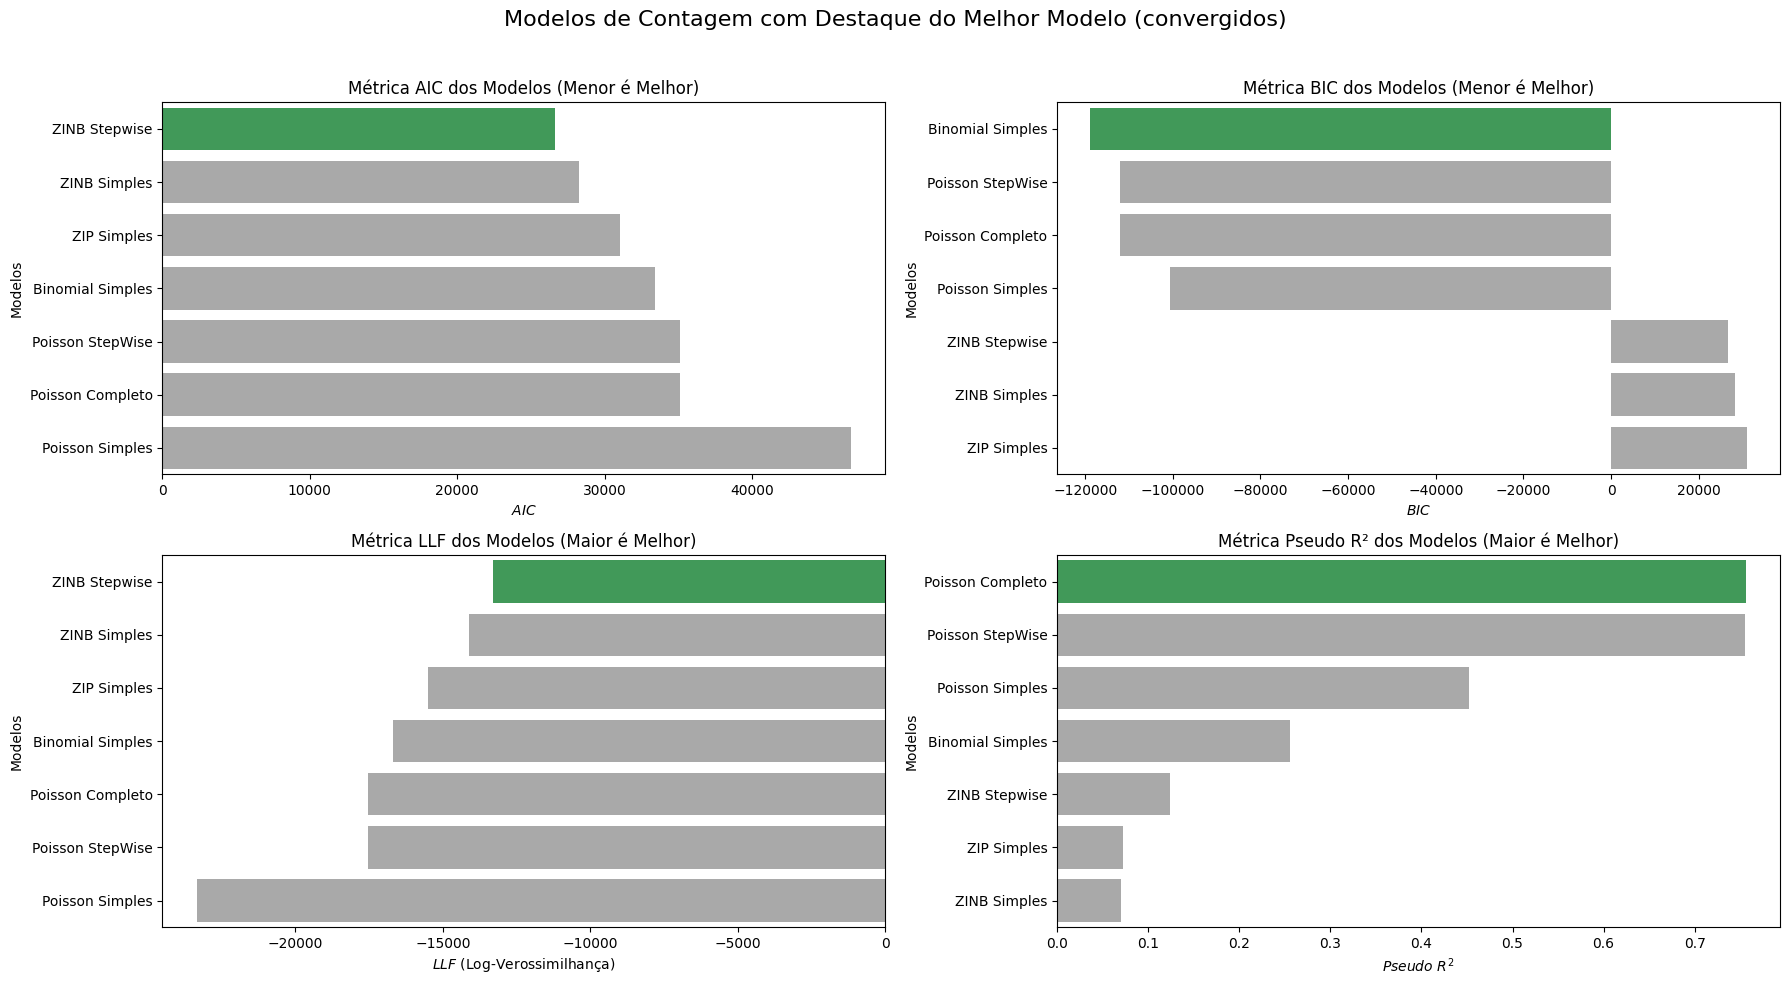

In [75]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['title']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['title']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='title', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['title']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['title']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['title']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

### Seleção do modelo e identificação das features

In [76]:
best_model_llf

'ZINB Stepwise'

In [77]:
indice = titles.index(best_model_llf)
best_model = models[indice]
best_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: ZeroInflatedNegativeBinomialP
==============================================================================
Model:              ZeroInflatedNegativeBinomialP Pseudo R-squared: 0.123     
Dependent Variable: y                             AIC:              26653.5691
Date:               2025-08-06 20:02              BIC:              26797.4449
No. Observations:   14363                         Log-Likelihood:   -13308.   
Df Model:           11                            LL-Null:          -15182.   
Df Residuals:       14351                         LLR p-value:      0.0000    
Converged:          1.0000                        Scale:            1.0000    
Method:             MLE                                                       
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
inflate_const                 -6.2416   0.7082  -8.8133 0.0000 -7.6297 -4.8536
inflate_max_per_capita_income -2.0390   0.4335  -4.7038 0.0000 -2.8887 -1.1894
inflate_min_current_age       -1.6071   0.1849  -8.6919 0.0000 -1.9695 -1.2447
inflate_median_credit_score    0.6369   0.1450   4.3927 0.0000  0.3527  0.9211
inflate_max_credit_limit      -2.1911   0.4832  -4.5348 0.0000 -3.1381 -1.2441
inflate_min_per_capita_income  0.2996   0.1195   2.5078 0.0122  0.0654  0.5337
const                         -0.9026   0.0258 -34.9398 0.0000 -0.9533 -0.8520
max_total_debt                 0.1720   0.0290   5.9375 0.0000  0.1152  0.2287
previous_frauds                0.8519   0.0192  44.2749 0.0000  0.8142  0.8896
median_amount                 -1.2769   0.0508 -25.1186 0.0000 -1.3765 -1.1772
target_city_0                 -0.2629   0.0226 -11.6252 0.0000 -0.3072 -0.2186
target_description_0          -0.2408   0.0196 -12.3081 0.0000 -0.2791 -0.2025
max_num_credit_cards           0.1949   0.0259   7.5369 0.0000  0.1442  0.2456
min_current_age               -0.1927   0.0236  -8.1601 0.0000 -0.2390 -0.1464
min_total_debt                 0.9107   0.0518  17.5752 0.0000  0.8091  1.0123
median_credit_score            0.1416   0.0288   4.9118 0.0000  0.0851  0.1981
max_current_age                0.1259   0.0325   3.8710 0.0001  0.0622  0.1897
median_num_credit_cards        0.0958   0.0295   3.2486 0.0012  0.0380  0.1535
alpha                          2.5410   0.0815  31.1774 0.0000  2.3813  2.7008
==============================================================================

"""

In [78]:
df_features_model = pd.merge(best_model.params.rename('coefficients'),
         best_model.pvalues.rename('p_value'),
         how='inner',
         left_index=True,
         right_index=True) \
  .assign(component=lambda data: ['classification' if 'inflate_' in index else 'count' for index in data.index.to_list()]) \
  .assign(feature=lambda data: [index.replace('inflate_', '') for index in data.index.to_list()]) \
  .sort_values(by='component').reset_index(drop=True)[['feature', 'component', 'coefficients', 'p_value']]
df_features_model


feature       component  coefficients        p_value
0                     const  classification     -6.241632   1.215608e-18
1     max_per_capita_income  classification     -2.039043   2.553210e-06
2           min_current_age  classification     -1.607148   3.564249e-18
3       median_credit_score  classification      0.636941   1.119307e-05
4          max_credit_limit  classification     -2.191086   5.764879e-06
5     min_per_capita_income  classification      0.299574   1.215008e-02
6           max_current_age           count      0.125907   1.083816e-04
7       median_credit_score           count      0.141587   9.026545e-07
8            min_total_debt           count      0.910706   3.812555e-69
9           min_current_age           count     -0.192723   3.347230e-16
10     max_num_credit_cards           count      0.194874   4.813013e-14
11            median_amount           count     -1.276854  3.115272e-139
12            target_city_0           count     -0.262915   3.067999e-31
13  median_num_credit_cards           count      0.095764   1.159638e-03
14          previous_frauds           count      0.851909   0.000000e+00
15           max_total_debt           count      0.171965   2.894379e-09
16                    const           count     -0.902634  1.851201e-267
17     target_description_0           count     -0.240796   8.190198e-35
18                    alpha           count      2.541021  2.157059e-213

In [93]:
X_sample = X.drop(columns=['frauds']).median(axis=0).to_frame().T
for column in X_sample.columns:
  X_sample[column] = np.log(X_sample[column] + 1)
X_sample_adjusting = pd.DataFrame(standard_scaler.transform(X_sample), columns=X_sample.columns)
X_sample_adjusting = X_sample_adjusting[np.unique([column for column in df_features_model['feature'].to_list() if column in X_sample_adjusting.columns])]
X_sample_adjusting = X_scaler.sample(5)
X_sample_adjusting

median_amount  max_amount  min_current_age  median_current_age  \
7082        0.269140   -1.012843        -0.342726           -0.224859   
5528       -0.659432    0.660164        -0.342726           -0.114574   
12398       0.177937    0.563037        -0.342726           -0.829254   
3429        0.312071    1.076542         0.664966            1.224886   
9668       -0.966434   -0.582821        -1.350418           -0.189683   

       max_current_age  min_per_capita_income  median_per_capita_income  \
7082          0.217801              -0.456245                  0.479833   
5528         -0.096757              -0.456245                  0.887980   
12398         0.217801              -0.456245                  0.166766   
3429          0.217801              -0.456245                  0.230571   
9668          0.846917              -0.456245                  1.350810   

       max_per_capita_income  min_total_debt  median_total_debt  ...  \
7082                0.487581       -0.017755          -0.666581  ...   
5528               -0.592777       -0.017755           0.347980  ...   
12398               1.143023       -0.017755          -0.456461  ...   
3429                1.143023       -0.017755          -1.170752  ...   
9668               -0.592777       -0.017755           0.174507  ...   

       min_num_credit_cards  median_num_credit_cards  max_num_credit_cards  \
7082              -0.020033                -0.027224             -0.964473   
5528              -0.020033                -0.060003              0.957381   
12398             -0.020033                -0.467953             -0.964473   
3429              -0.020033                -0.118253              0.957381   
9668              -0.020033                 0.493374              0.957381   

       median_credit_limit  max_credit_limit  target_city_0  target_city_1  \
7082              1.427219          1.168361       0.078911          -0.03   
5528              0.292201          1.168361       0.078911          -0.03   
12398             0.572254          0.859447       0.078911          -0.03   
3429             -0.300557         -0.137229       0.078911          -0.03   
9668              0.601467          1.168361       0.078911          -0.03   

       target_description_0  target_description_2  previous_frauds  
7082               0.136664             -0.099345        -0.552282  
5528               0.136664             -0.099345         1.810669  
12398              0.136664             -0.099345         1.810669  
3429               0.136664             -0.099345        -0.552282  
9668               0.136664             -0.099345        -0.552282  

[5 rows x 24 columns]

In [94]:
def generate_playload(df_features_model, data: pd.DataFrame):
  exog = df_features_model[df_features_model['component'] == 'count']['feature'].to_list()
  exog_infl = df_features_model[df_features_model['component'] == 'classification']['feature'].to_list()

  data_exog = data[[ex for ex in exog if ex in data.columns]]
  data_exog_infl = data[[ex for ex in exog_infl if ex in data.columns]]

  data_exog['const'] = 1
  data_exog = data_exog[[column for column in exog]]
  data_exog_infl['const'] = 1
  data_exog_infl = data_exog_infl[[column for column in exog_infl]]
  data_exog_infl.columns = [f'inflate_{column}' for column in data_exog_infl.columns]

  return data_exog, data_exog_infl


In [95]:
exog, exog_infl = generate_playload(df_features_model.query('feature != "alpha"'), X_sample_adjusting)

In [96]:
[round(pred) for pred in best_model.predict(exog=exog.values, exog_infl=exog_infl.values)]

[1, 10, 8, 0, 2]

In [97]:
y.loc[X_sample_adjusting.index]

7082     0
5528     5
12398    0
3429     0
9668     3
Name: frauds, dtype: int32